# Reinforcement Learning with Atari Tennis
The aim of this notebook is to experiment with Reinforcement Learning (RL) by exploring its application in mastering the classic Atari game, Tennis.

The goal is to develop and train an RL agent capable of playing Atari Tennis at a proficient level.

> Note:
Running the entire notebook will take a considerable amount of time. It is recommended to run the all cells above the training loop section to initialize and set up the model, agent, and environment as it can be executed in a short amount of time and then proceed to run the training and testing as these processes will take longest.

In [2]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
from ale_py import ALEInterface
from ale_py.roms import Tennis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from datetime import datetime
from collections import deque
import time
import tensorflow as tf
import os

## Loading the ROM for Atari Tennis
In this section, we will load the ROM (Read-Only Memory) for the Atari Tennis game, which we will use to train our Reinforcement Learning (RL) model. The Atari Learning Environment (ALE) provides a convenient interface to interact with Atari 2600 games, allowing us to simulate the game environment and retrieve observations and rewards.

In [3]:
# Load the ROM for Atari Tennis
ale = ALEInterface()
ale.loadROM(Tennis)

## Hyperparameters 
In this section, we define the key hyperparameters and training parameters that will guide the learning process of our RL agent. These parameters play a crucial role in determining the efficiency and effectiveness of the training.

Hyperparameters are the variables that control the learning process. Fine-tuning these parameters can significantly impact the performance of the RL agent. Below are the hyperparameters used in this project:
* `learning_rate` - The learning rate determines how much new information overrides the old information.
* `exploration_factor` - The exploration factor dictates the probability of the agent exploring new actions versus exploiting known actions.
* `exploration_factor_min` - Minimum probability of exploration.
* `exploration_decay` - Rate at which the exploration factor decreases over time.
* `discount_factor` - The discount factor represents the importance of future rewards.
* `training_episodes` - The number of episodes during which the agent will interact with the environment to learn and improve its performance.
* `testing_episodes` - The number of episodes used to evaluate the performance of the trained agent without further learning.
* `max_steps` - The maximum number of steps the agent can take in a single episode. This prevents episodes from running indefinitely and ensures consistent evaluation.
* `replay_buffer_size` - Capacity of the replay buffer that stores experiences for training. A larger buffer can store more experiences but requires more memory.
* `batch_size` - Size of the batch sampled from the replay buffer for training the model. Larger batches can provide more stable updates but require more computational resources.
* `save_interval` - Interval (in episodes) at which the model is saved during training. Regular saving helps to preserve the model's progress and allows for resuming training or evaluation from a checkpoint.
* `priority_exponent` - Exponent used in prioritization for the replay buffer. This controls how much prioritization is applied based on the TD-error.
* `importance_sampling` - Initial value for importance sampling weight. This helps to correct the bias introduced by prioritized sampling, ensuring that updates are unbiased over the long run.

In [4]:
# Hyperparameters
hyperparameters = {
    "learning_rate": 0.1,           # Learning Rate
    "exploration_factor": 1.0,      # Exploration Factor (initial)
    "exploration_factor_min":0.1,   # Minimum Exploration Factor
    "exploration_decay":0.995,      # Exploration Decay
    "discount_factor": 0.99,        # Discount Factor
    "training_episodes": 500,       # Number of training episodes
    "testing_episodes": 5000,       # Number of testing episdoes
    "max_steps": 100,               # Maximum steps per episode
    "replay_buffer_size": 10000,    # Capacity of the replay buffer
    "batch_size": 32,               # Size of batch to start sampling from 
    "save_interval": 100,           # Interval to save mmodel during training
    "priority_exponent": 0.6,       # Exponent used in prioritization for replay buffer
    "importance_sampling": 0.4,     # Initial value for importance sampling weight
}

## Initializing the Environment
In this section, we initialize the game environment for our RL agent using the Gym library, which provides a standard API for interfacing with various environments including Atari games. Specifically, we use the 'ALE/Tennis-v5' environment, which simulates the Atari Tennis game.

In [5]:
# Initialize the environment
env = gym.make('ALE/Tennis-v5',full_action_space=True)
env.reset() 

(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
         [ 82, 126,  45],
         [ 82, 126,  45]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
         [ 82, 126,  45],
         [ 82, 126,  45]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
  

## Action Space and Observation Space
By analyzing the action and observation spaces, we gain valuable insights into the complexity and structure of the Atari Tennis environment. The action space informs us about the available actions that the agent can choose from, while the observation space describes the format of the information provided to the agent about the current state of the game.

Understanding these spaces allows us to design RL algorithms and neural network architectures tailored to the specific characteristics of the environment, ultimately facilitating effective learning and decision-making.

In [6]:
actions = env.action_space.n 
height, width, channels = env.observation_space.shape

## Building the Neural Network Model

We define a function `build_model` that constructs a neural network model follows a typical architecture for deep Q-networks (DQN) used in Atari game playing agents. It is designed to process raw pixel inputs from the game environment and output Q-values for each possible action. This model will serve as the backbone for our RL agent, allowing it to learn and make decisions based on the game's observations.

Function parameters:
* `height` - Height of the input image.
* `width` - Width of the input image.
* `channels` - Number of color channels in the input image.
* `actions` - Number of possible actions in the environment.

Model Architecture:
* `Convolutional Layers` - These layers are designed to extract features from the input image. Uses ReLU activation functions.
* `Flatten ` - The output of the convolutional layers is flattened to prepare it for input to the fully connected layers.
* `Fully Connected Layers` - These layers (Dense) with ReLU activation functions aims to process the extracted features and learn representations relevant for decision-making.
* `Output Layer` - A fully connected layer with a linear activation function, producing the Q-values for each action in the environment.


### Model Architecture

In [7]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(height,width,channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(actions,activation='linear'))
    return model

In [8]:
model = build_model(height, width, channels, actions)
model.summary()

d:\Projects\RL-tennis\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 51, 39, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 18, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    11,534,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,746,738 (44.81 MB)

 Trainable params: 11,746,738 (44.81 MB)

 Non-trainable params: 0 (0.00 B)

### DQN Agent

In [9]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha=0.6):
        self.size = size
        self.alpha = alpha
        self.buffer = deque(maxlen=size)
        self.priorities = deque(maxlen=size)
    
    def add(self, experience, error):
        priority = (error + 1e-5) ** self.alpha
        self.buffer.append(experience)
        self.priorities.append(priority)

    def sample(self, batch_size, beta=0.4):
        scaled_priorities = np.array(self.priorities) ** beta
        
        # Avoid NaN values
        if np.any(np.isnan(scaled_priorities)):
            scaled_priorities = np.nan_to_num(scaled_priorities, nan=0.0, posinf=0.0, neginf=0.0)
        
        total_priority = sum(scaled_priorities)
        
        # Check if total_priority is zero or very close to zero
        if total_priority == 0 or np.isclose(total_priority, 0.0):
            # Handle the edge case where all priorities might be zero
            sample_probs = np.ones_like(scaled_priorities) / len(scaled_priorities)
        else:
            sample_probs = scaled_priorities / total_priority
        
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * sample_probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, weights

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            priority = (error + 1e-5) ** self.alpha
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)
    
class DQNAgent:
    def __init__(self, model, actions, hyperparameters):
        self.model = model
        self.actions = actions
        self.learning_rate = hyperparameters["learning_rate"]
        self.epsilon = hyperparameters["exploration_factor"]
        self.epsilon_min = hyperparameters["exploration_factor_min"]
        self.epsilon_decay = hyperparameters["exploration_decay"]
        self.optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mse')
        self.replay_buffer = PrioritizedReplayBuffer(hyperparameters["replay_buffer_size"])
        self.batch_size = hyperparameters["batch_size"]
        self.discount_factor = hyperparameters["discount_factor"]
        self.priority_exponent = hyperparameters["priority_exponent"]
        self.importance_sampling = hyperparameters["importance_sampling"]

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.actions)
        else:
            q_values = self.model.predict(state,verbose=0)
            return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        q_values = self.model.predict(state, verbose=0)
        next_q_values = self.model.predict(next_state, verbose=0)
        target = reward
        if not done:
            target = reward + self.discount_factor * np.max(next_q_values[0])
        error = abs(target - q_values[0][action])
        self.replay_buffer.add((state, action, reward, next_state, done), error)

    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        minibatch, indices, weights = self.replay_buffer.sample(self.batch_size, self.importance_sampling)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = np.vstack(states)
        next_states = np.vstack(next_states)
        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)

        targets = q_values.copy()
        errors = np.zeros(self.batch_size)
        
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target = rewards[i] + self.discount_factor * np.max(next_q_values[i])
            errors[i] = abs(target - q_values[i][actions[i]])
            targets[i][actions[i]] = target

        self.replay_buffer.update_priorities(indices, errors)
        self.model.fit(states, targets, sample_weight=weights, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def build_agent(model,actions,hyperparameters):
    agent = DQNAgent(model=model, actions=actions,hyperparameters=hyperparameters)
    return agent

In [10]:
agent = build_agent(model,actions,hyperparameters)

## Training Loop

The training loop is a critical part of developing a reinforcement learning agent. The agent interacts with the environment, collects experiences, and updates its neural network model to improve its performance over time.

Training Process:
1) **Environment Reset**: 

    At the start of each episode, the environment is reset to its initial state.
2) **Action Selection**: 

    The agent selects actions based on the current state using an epsilon-greedy policy, balancing exploration and exploitation.
3) **Experience Collection**: 

    The agent performs the selected action, observes the next state and reward, and stores the experience in the replay buffer.
4) **Replay and Update**: 

    The agent samples a batch of experiences from the replay buffer, computes the target Q-values, and updates the neural network model.
5) **Performance Recording**: 

    The total reward for each episode is recorded, and the model is periodically saved.

> Note:
Running the training loop may take a considerable amount of time. For quicker training, you can reduce the number of training episodes. Adjust the training_episodes hyperparameter to a smaller value to shorten the training duration.

In [ ]:
# Training loop
performance_record = []  # List to store performance of each episode
best_average_reward = -np.inf  
average_reward = 0
start_time = time.time()

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for episode in range(hyperparameters["training_episodes"]):
    
    state_tuple = env.reset()
    observation = state_tuple[0]  # Extract the observation from the tuple
    state = np.expand_dims(observation, axis=0)  # Add batch dimension
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        observations = env.step(action)
        next_state = observations[0]
        reward = observations[1]
        done = observations[2]
        next_state = np.expand_dims(next_state, axis=0)  # Add batch dimension
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
        
    agent.replay()
    performance_record.append(total_reward)

    # Save the model weights every save_interval episodes
    if (episode + 1) % hyperparameters["save_interval"] == 0:
        model_filename = os.path.join(model_dir, f"model_episode_{episode + 1}.keras")
        model.save(model_filename)
    
    # Track the best performing model
    average_reward = np.mean(performance_record[-100:])
    if average_reward > best_average_reward:
        best_average_reward = average_reward
        model.save(os.path.join(model_dir, "best_model.keras"))

    print(f"--- Episode {episode + 1} finished ---")
    
end_time = time.time()
training_duration = end_time - start_time
hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training Completed in {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

env.close()

## Testing Loop

After training, it is essential to evaluate the performance of the trained agent. The agent's actions are rendered to visualize its gameplay.

Testing Process:
1) **Model Loading**: 

    The best model saved during training is loaded.
2) **Environment Initialization**: 

    The environment is set up in rendering mode to visualize the agent's actions.
3) **Action Execution**: 

    The agent interacts with the environment using the trained policy, without further learning.
4) **Performance Recording**: 

    The total reward for each testing episode is recorded and printed.

> Note:
Running the testing loop may take a considerable amount of time. For quicker testing, you can reduce the number of testing episodes. Adjust the testing_episodes hyperparameter to a smaller value to shorten the testing duration.

### Test Performance of Model after 500 Training Episodes.

In [11]:
# Load the saved model
saved_model_path = "models/agent_model_episode_500.keras"  
loaded_model = load_model(saved_model_path)

# Create a new agent with the loaded model
testing_agent = build_agent(loaded_model,actions,hyperparameters)

env = gym.make('ALE/Tennis-v5',full_action_space=True)
env.reset() 

test_performance_record = []

# Testing loop
for episode in range(hyperparameters["testing_episodes"]):
    state_tuple = env.reset()
    observation = state_tuple[0]  # Extract the observation from the tuple
    state = np.expand_dims(observation, axis=0)  # Add batch dimension
    total_reward = 0
    done = False
    while not done:
        #env.render()
        action = testing_agent.act(state)
        observations = env.step(action)
        next_state = observations[0]
        reward = observations[1]
        done = observations[2]
        next_state = np.expand_dims(next_state, axis=0)  # Add batch dimension
        state = next_state
        total_reward += reward
    test_performance_record.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
    
env.close()

Episode: 1, Total Reward: -24.0
Episode: 2, Total Reward: -24.0
Episode: 3, Total Reward: -24.0
Episode: 4, Total Reward: -24.0
Episode: 5, Total Reward: -24.0
Episode: 6, Total Reward: -24.0
Episode: 7, Total Reward: -24.0
Episode: 8, Total Reward: -24.0
Episode: 9, Total Reward: -24.0
Episode: 10, Total Reward: -24.0
Episode: 11, Total Reward: -24.0
Episode: 12, Total Reward: -24.0
Episode: 13, Total Reward: -24.0
Episode: 14, Total Reward: -24.0
Episode: 15, Total Reward: -23.0
Episode: 16, Total Reward: -24.0
Episode: 17, Total Reward: -24.0
Episode: 18, Total Reward: -24.0
Episode: 19, Total Reward: -24.0
Episode: 20, Total Reward: -24.0
Episode: 21, Total Reward: -24.0
Episode: 22, Total Reward: -24.0
Episode: 23, Total Reward: -24.0
Episode: 24, Total Reward: -23.0
Episode: 25, Total Reward: -24.0
Episode: 26, Total Reward: -24.0
Episode: 27, Total Reward: -24.0
Episode: 28, Total Reward: -24.0
Episode: 29, Total Reward: -24.0
Episode: 30, Total Reward: -24.0
Episode: 31, Total 

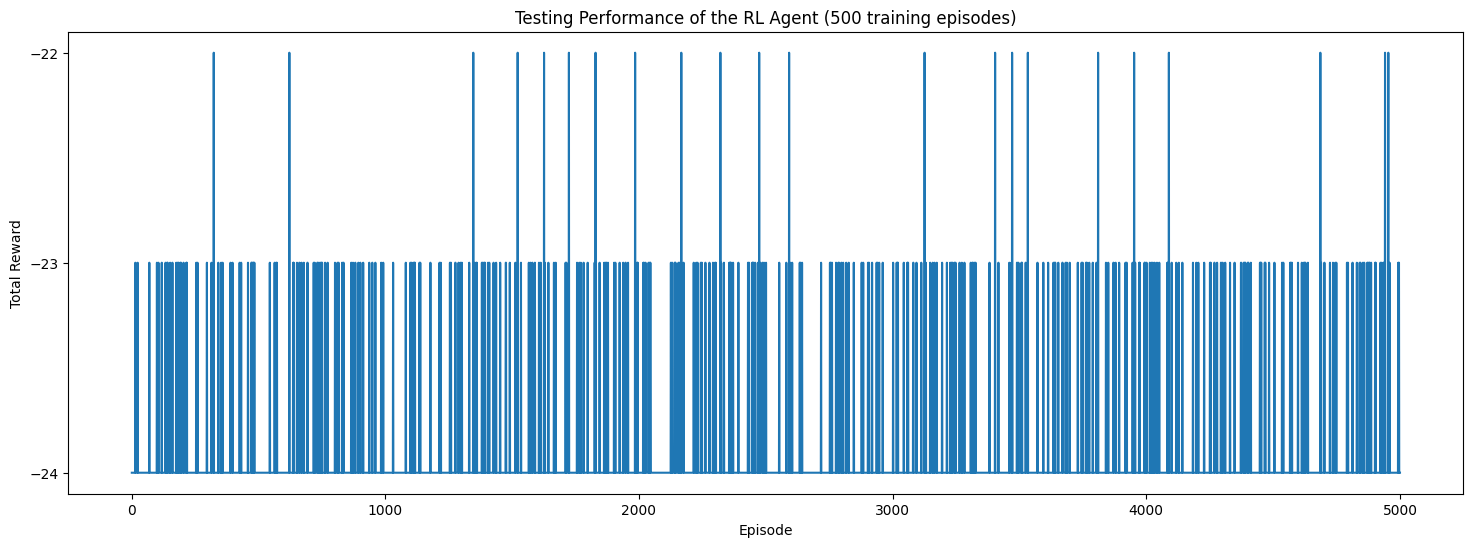

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(range(1, hyperparameters["testing_episodes"] + 1), test_performance_record)
plt.xlabel('Episode')
plt.xticks(range(0, hyperparameters["testing_episodes"] + 1, 1000))
plt.ylabel('Total Reward')
plt.yticks(range(int(min(test_performance_record)), int(max(test_performance_record)) + 1, 1))
plt.title('Testing Performance of the RL Agent (500 training episodes)')
plt.show()

The above results shows the testing performance of the model after 500 training episodes. We can observe that 500 training episodes is not sufficient for the agent and requires more training for it to reach more acceptable levels of performance. Although it is yet to be optimal performance, we can see that it does have performance consistency where the rewards seem to vary between -24 and -21, with most of the values clustered around -23. This indicates some level of stability in the agent's performance.

In [ ]:
# Randomized Algorithm (Low Performance) -- For Comparison Purposes

# env = gym.make('ALE/Tennis-v5',full_action_space=True,render_mode='human')
# env.reset() 
# def random_agent(hyperparameters):
#     episodes = hyperparameters["training_episodes"]

#     for episode in range(1, episodes+1):
#         state = env.reset()
#         done = False
#         score = 0 

#         while not done:
#             env.render()
#             action = env.action_space.sample()
#             observations = env.step(action)
#             next_state = observations[0]
#             reward = observations[1]
#             done = observations[2]
#             score+=reward
#         print('Episode:{} Score:{}'.format(episode, score))
#     env.close()

# random_agent(hyperparameters)